In [1]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


# LOAD DICOM IMAGE

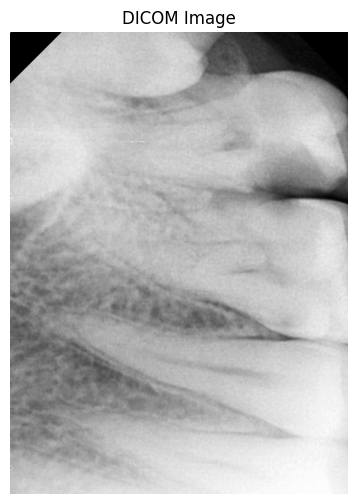

{'Patient ID': '20250115_171637', 'Modality': 'IO', 'Dimensions': (1095, 800), 'Bits Stored': 8, 'Photometric Interpretation': 'MONOCHROME2'}


In [70]:
import pydicom
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load DICOM
dicom_path = "/kaggle/input/dicom-data/Images/IS20250115_171841_9465_61003253.dcm"
dicom_data = pydicom.dcmread(dicom_path)
pixel_array = dicom_data.pixel_array

# Normalize image
norm_img = cv2.normalize(pixel_array.astype(np.float32), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Show image
plt.figure(figsize=(6,6))
plt.imshow(norm_img, cmap='gray')
plt.title("DICOM Image")
plt.axis("off")
plt.show()

# Print key metadata
print({
    "Patient ID": dicom_data.get("PatientID", "N/A"),
    "Modality": dicom_data.get("Modality", "N/A"),
    "Dimensions": pixel_array.shape,
    "Bits Stored": dicom_data.get("BitsStored", "N/A"),
    "Photometric Interpretation": dicom_data.get("PhotometricInterpretation", "N/A")
})


# COMPARISON WITH REFRENCE IMAGE

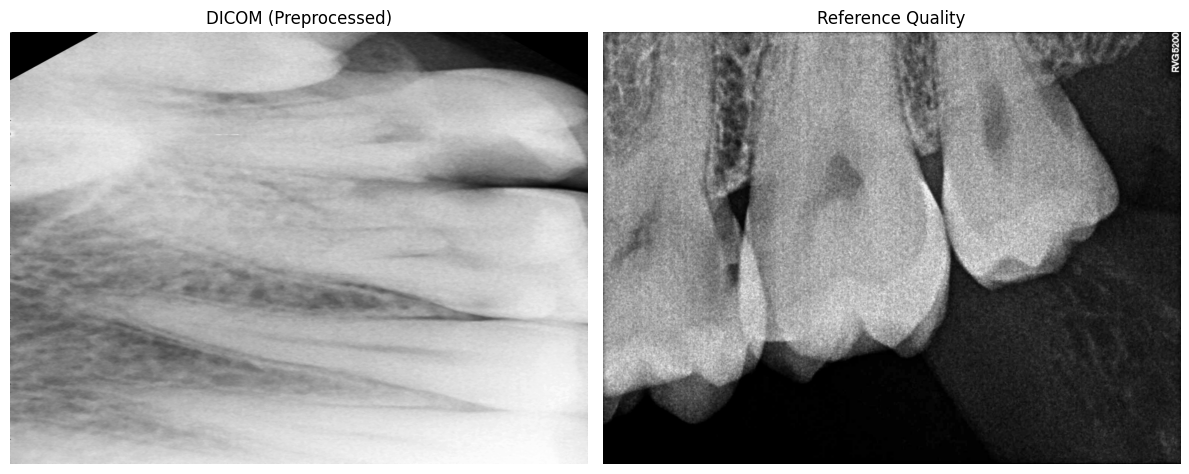

In [37]:
from PIL import Image

# Load reference image
ref_img = np.array(Image.open("/kaggle/input/dicom-data/Images/Reference_Output_Quality.jpg").convert("L"))

# Resize DICOM image to match reference (for visual comparison)
resized_norm = cv2.resize(norm_img, ref_img.shape[::-1])

# Show side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(resized_norm, cmap='gray')
ax[0].set_title("DICOM (Preprocessed)")
ax[0].axis('off')

ax[1].imshow(ref_img, cmap='gray')
ax[1].set_title("Reference Quality")
ax[1].axis('off')
plt.tight_layout()
plt.show()


✅ Step 3: Image Quality Metrics
We'll compute four key metrics:



* Brightness	Average pixel intensity
* Contrast	Intensity spread (standard deviation, RMS contrast)
* Sharpness	Image edge clarity (Laplacian variance, Tenengrad)
* Noise	Random pixel variation (local variance, wavelet noise estimate)

In [38]:
def compute_brightness(image):
    mean_brightness = np.mean(image)
    return mean_brightness

def plot_histogram(image, title="Histogram"):
    plt.figure(figsize=(6,4))
    plt.hist(image.ravel(), bins=256, color='gray', alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()


In [39]:
def compute_contrast_metrics(image):
    std_dev = np.std(image)
    rms_contrast = np.sqrt(np.mean((image - np.mean(image)) ** 2))
    
    # Michelson contrast (for normalized image)
    I_max, I_min = np.max(image), np.min(image)
    michelson = (I_max - I_min) / (I_max + I_min + 1e-8)
    
    return std_dev, rms_contrast, michelson


In [40]:
import cv2

def compute_sharpness(image):
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()
    
    # Tenengrad method
    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    tenengrad = np.sqrt(gx**2 + gy**2).mean()
    
    return laplacian_var, tenengrad


In [41]:
def estimate_noise(image, patch_size=32):
    h, w = image.shape
    patch = image[h//2 - patch_size//2 : h//2 + patch_size//2,
                  w//2 - patch_size//2 : w//2 + patch_size//2]
    return np.std(patch)


In [42]:
def characterize_image(image):
    brightness = compute_brightness(image)
    std_dev, rms_contrast, michelson = compute_contrast_metrics(image)
    lap_var, tenengrad = compute_sharpness(image)
    noise_std = estimate_noise(image)
    
    print("🔆 Brightness (mean):", round(brightness, 2))
    print("🌗 Contrast - Std Dev:", round(std_dev, 2), 
          "| RMS:", round(rms_contrast, 2), 
          "| Michelson:", round(michelson, 3))
    print("🔍 Sharpness - Laplacian Var:", round(lap_var, 2), 
          "| Tenengrad:", round(tenengrad, 2))
    print("🔉 Noise Std (central patch):", round(noise_std, 2))
    
    plot_histogram(image, title="Image Histogram")


🔆 Brightness (mean): 174.68
🌗 Contrast - Std Dev: 49.16 | RMS: 49.16 | Michelson: 1.0
🔍 Sharpness - Laplacian Var: 82.74 | Tenengrad: 17.86
🔉 Noise Std (central patch): 4.08


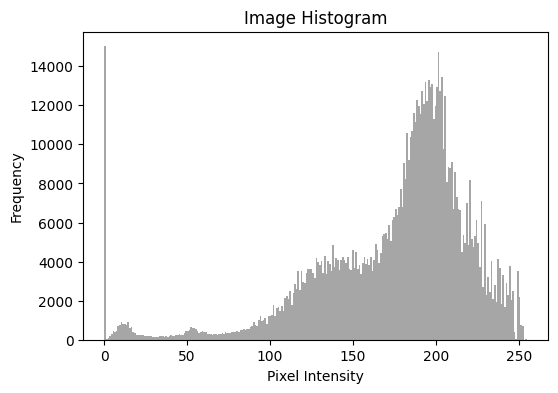

In [43]:
characterize_image(norm_img)

# Static Preprocessing (Baseline)

** Global Histogram Equalization**

In [44]:
from skimage import exposure

def apply_histogram_equalization(image):
    eq_img = exposure.equalize_hist(image)  # Returns float image [0,1]
    eq_img = (eq_img * 255).astype(np.uint8)  # Convert back to uint8
    return eq_img


In [45]:
def apply_unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    
    return sharpened


In [46]:
def apply_basic_denoising(image):
    median = cv2.medianBlur(image, 3)
    gaussian = cv2.GaussianBlur(median, (3, 3), 0)
    return gaussian


In [47]:
def static_preprocessing_pipeline(image):
    print("Applying static pipeline...")
    
    eq_img = apply_histogram_equalization(image)
    sharp_img = apply_unsharp_mask(eq_img)
    denoised_img = apply_basic_denoising(sharp_img)
    
    return denoised_img


In [48]:
def visualize_pipeline_output(original, processed):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(processed, cmap='gray')
    axs[1].set_title("Static Preprocessed")
    axs[1].axis('off')
    
    plt.show()


In [49]:
static_processed = static_preprocessing_pipeline(norm_img)

Applying static pipeline...


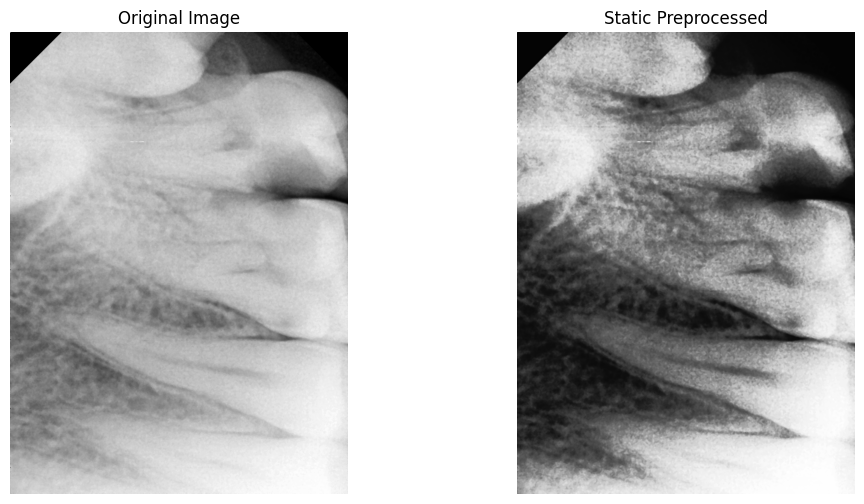

In [50]:
visualize_pipeline_output(norm_img, static_processed)

# Adaptive approach(1)

**WE WILL DO EVERYTHING AGAIN** 

1. LOAD DICOM IMAGE
2. compute brightness, contrast, sharpness and noise
3. adaptively compute adaptive_denoise, adaptive_contrast, adaptive_sharpen
4. Final Adaptive preprocess function 

Brightness: 174.68, Contrast: 49.16, Sharpness: 82.74, Noise: 7.95


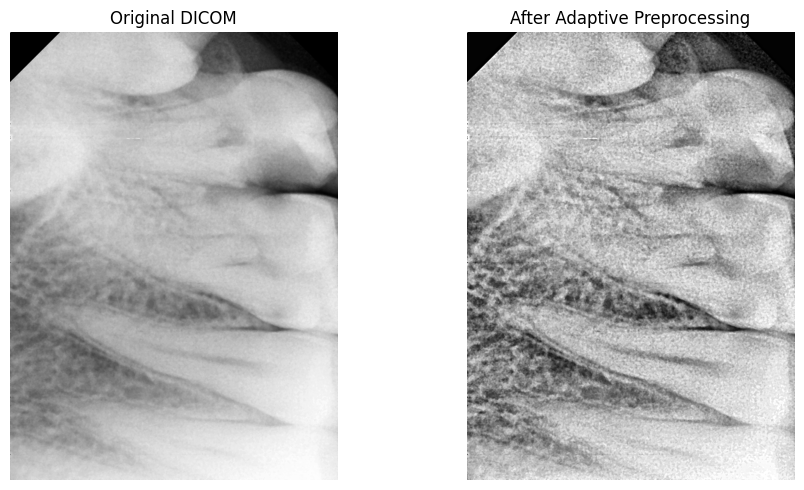

In [51]:
import pydicom
import cv2
import numpy as np
from matplotlib import pyplot as plt

# ---------------------------
# Load and normalize DICOM
# ---------------------------
def load_dicom_image(path):
    ds = pydicom.dcmread(path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize to 8-bit [0,255]
    image -= np.min(image)
    image /= np.max(image)
    image *= 255.0

    return image.astype(np.uint8)

# ---------------------------
# Image Quality Metrics
# ---------------------------
def get_brightness(image):
    return np.mean(image)

def get_contrast(image):
    return np.std(image)

def get_sharpness(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

def get_noise(image):
    h, w = image.shape
    roi = image[h//2 - h//20:h//2 + h//20, w//2 - w//20:w//2 + w//20]
    return np.std(roi)

# ---------------------------
# Adaptive Enhancement Steps
# ---------------------------
def adaptive_denoise(image, noise_level):
    if noise_level > 30:
        return cv2.fastNlMeansDenoising(image, h=10)
    elif noise_level > 15:
        return cv2.bilateralFilter(image, 9, 75, 75)
    else:
        return cv2.GaussianBlur(image, (3, 3), 0.5)

def adaptive_contrast(image, contrast_level):
    if contrast_level < 30:
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        return clahe.apply(image)
    elif contrast_level < 50:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
        return clahe.apply(image)
    else:
        return image

def adaptive_sharpen(image, sharpness_level):
    if sharpness_level > 100:
        return image
    elif sharpness_level > 50:
        amount = 1.0
    else:
        amount = 1.5

    blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=3)
    sharpened = cv2.addWeighted(image, 1 + amount, blurred, -amount, 0)
    return sharpened

# ---------------------------
# Complete Adaptive Pipeline
# ---------------------------
def adaptive_preprocess(image):
    brightness = get_brightness(image)
    contrast = get_contrast(image)
    sharpness = get_sharpness(image)
    noise = get_noise(image)

    print(f"Brightness: {brightness:.2f}, Contrast: {contrast:.2f}, Sharpness: {sharpness:.2f}, Noise: {noise:.2f}")

    denoised = adaptive_denoise(image, noise)
    contrasted = adaptive_contrast(denoised, contrast)
    final = adaptive_sharpen(contrasted, sharpness)

    return final

# ---------------------------
# Run on a DICOM File
# ---------------------------
if __name__ == "__main__":
    path = "/kaggle/input/dicom-data/Images/IS20250115_171841_9465_61003253.dcm"  # replace with your actual file path
    image = load_dicom_image(path)
    result = adaptive_preprocess(image)

    # Visualization using matplotlib
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original DICOM")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result, cmap='gray')
    plt.title("After Adaptive Preprocessing")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


**WHY THE STATIC PREPROCESSING FAILS IN EXTREME IMAGES**

In [18]:
def static_preprocessing(image):
    # Step 1: Global histogram equalization
    equalized = cv2.equalizeHist(image)

    # Step 2: Fixed sharpening
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(equalized, -1, kernel)

    # Step 3: Fixed denoising (e.g., median filter)
    denoised = cv2.medianBlur(sharpened, 3)

    return denoised


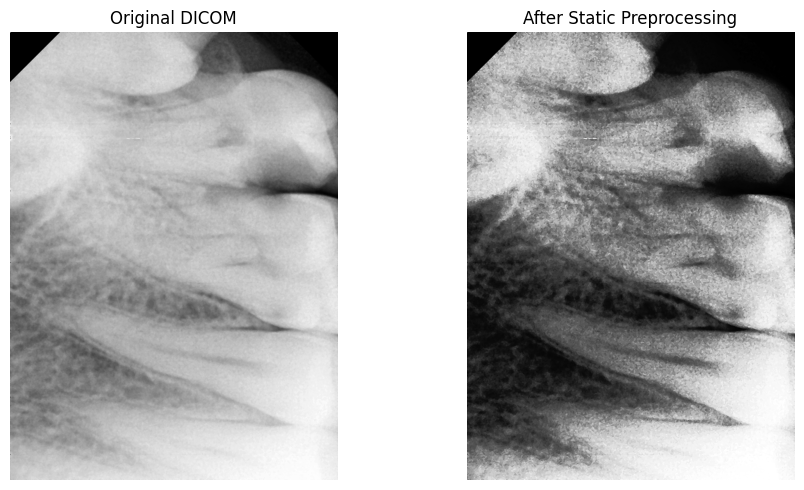

In [56]:
    path = "/kaggle/input/dicom-data/Images/IS20250115_171841_9465_61003253.dcm"  # replace with your actual file path
    image = load_dicom_image(path)
    static_preprocessed_image = static_preprocessing(image)
    # Visualization using matplotlib
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original DICOM")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(static_preprocessed_image, cmap='gray')
    plt.title("After Static Preprocessing")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Dynamic switching of enhancemengt paths -> Adaptive approach(2)
# conditional branching that changes entire preprocessing strategy (e.g., different pipelines for high noise + low contrast vs. high contrast + blur).

In [20]:
import cv2
import numpy as np
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float
from scipy.ndimage import gaussian_filter

def dynamic_adaptive_preprocessing(img, brightness, contrast, sharpness, noise_level):
    """
    Apply preprocessing strategy based on combined image quality metrics.
    """
    img = img.astype(np.uint8)
    processed = img.copy()

    if contrast < 40 and sharpness < 100:
        # Case A: Low contrast, low sharpness
        print("Strategy: Strong CLAHE + Strong Sharpening")
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
        processed = clahe.apply(processed)
        processed = unsharp_mask(processed, strength=2.0)

    elif contrast < 40 and noise_level > 20:
        # Case B: Low contrast, high noise
        print("Strategy: Mild CLAHE + Strong Denoising")
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
        processed = clahe.apply(processed)
        processed = denoise_image(processed, method="nlm")

    elif sharpness < 100 and noise_level < 10:
        # Case C: Low sharpness, low noise
        print("Strategy: Strong Sharpening Only")
        processed = unsharp_mask(processed, strength=2.5)

    else:
        # Case D: Normal/Moderate
        print("Strategy: Mild CLAHE + Gaussian Blur")
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(4, 4))
        processed = clahe.apply(processed)
        processed = cv2.GaussianBlur(processed, (3, 3), 0.5)

    return processed

def unsharp_mask(image, strength=1.5):
    blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=1)
    sharpened = cv2.addWeighted(image, 1 + strength, blurred, -strength, 0)
    return sharpened

def denoise_image(image, method="gaussian"):
    if method == "gaussian":
        return cv2.GaussianBlur(image, (5, 5), 1.0)
    elif method == "median":
        return cv2.medianBlur(image, 3)
    elif method == "nlm":
        image_float = img_as_float(image)
        sigma_est = np.mean(estimate_sigma(image_float, channel_axis=None))
        patch_kw = dict(patch_size=5, patch_distance=6, multichannel=False)
        denoised = denoise_nl_means(image_float, h=1.15 * sigma_est, fast_mode=True, **patch_kw)
        return (denoised * 255).astype(np.uint8)
    return image


**EXAMPLE RUN**

In [71]:
 get_brightness(image)
    

174.6803116438356

In [72]:
get_contrast(image)

49.159848059438495

In [73]:
get_sharpness(image)

82.74192048109403

In [74]:
get_noise(image)

7.94772268099757

In [75]:
dynamic_adaptive_preprocessing(norm_img, 130.8419680365297, 76.73253924124978, 116.69788312345449, 34.08735865905542)

Strategy: Mild CLAHE + Gaussian Blur


array([[202, 181,  23, ...,   2,   2,   2],
       [ 29,  26,   5, ...,   2,   2,   2],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [179, 192, 199, ..., 224, 224, 229],
       [185, 192, 193, ..., 224, 224, 224],
       [197, 197, 188, ..., 224, 221, 221]], dtype=uint8)

In [76]:
adaptive_preprocessed = dynamic_adaptive_preprocessing(norm_img, 130.8419680365297, 76.73253924124978, 116.69788312345449, 34.08735865905542)

Strategy: Mild CLAHE + Gaussian Blur


(-0.5, 799.5, 1094.5, -0.5)

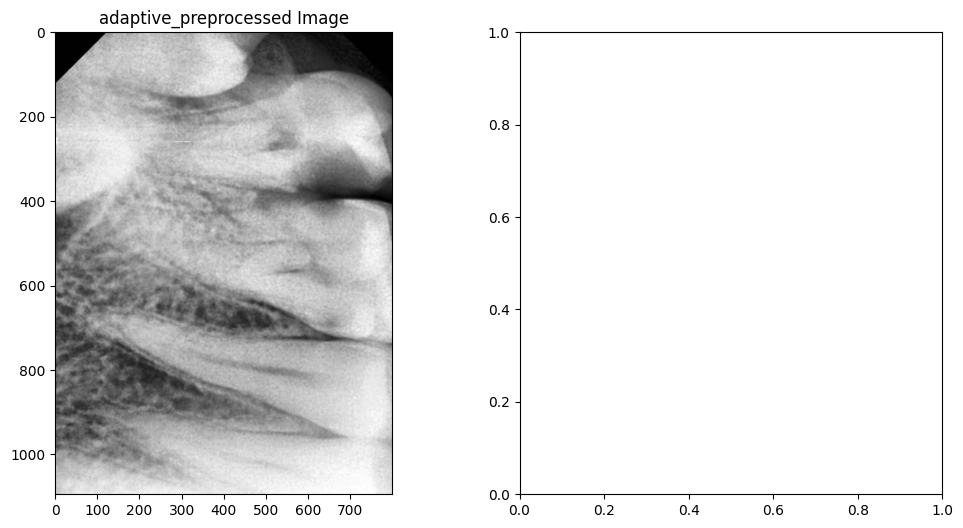

In [77]:

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(adaptive_preprocessed, cmap='gray')
    axs[0].set_title("adaptive_preprocessed Image")
    axs[0].axis('on')

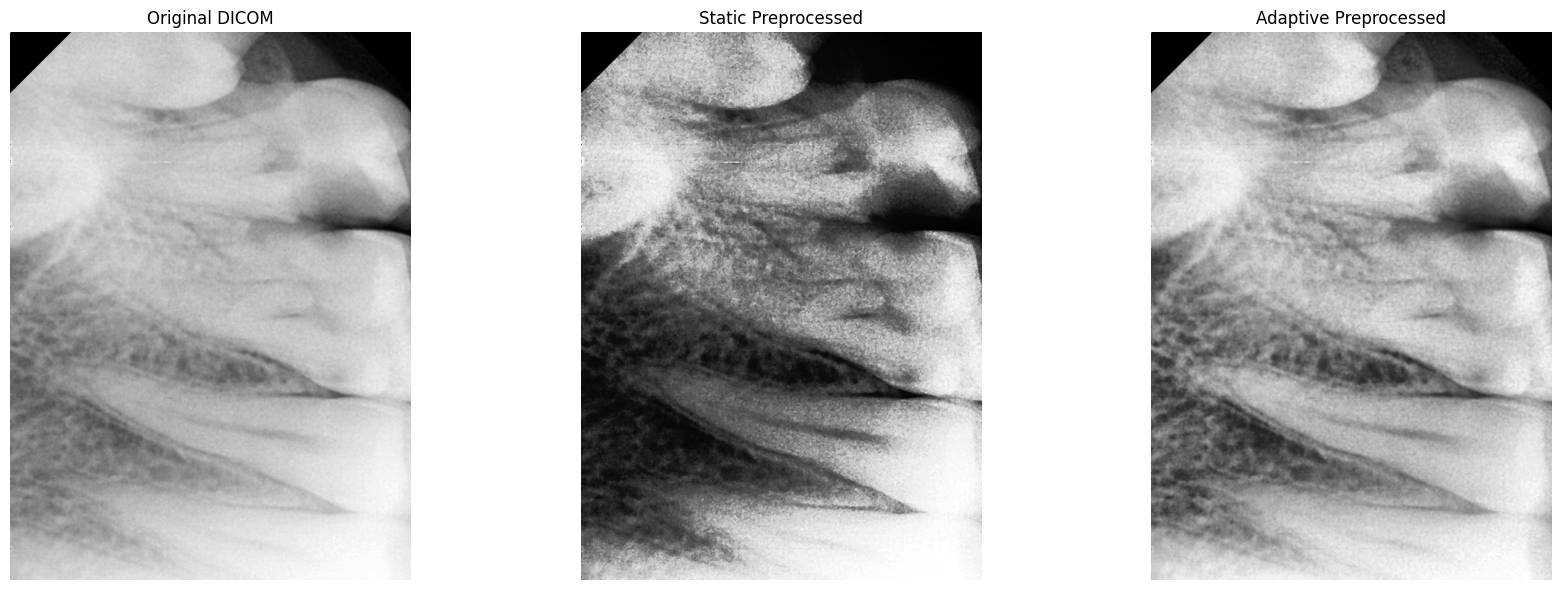

In [81]:
import matplotlib.pyplot as plt

# Plot all three side-by-side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original DICOM")
axs[0].axis('off')

axs[1].imshow(static_preprocessed_image, cmap='gray')
axs[1].set_title("Static Preprocessed")
axs[1].axis('off')

axs[2].imshow(adaptive_preprocessed, cmap='gray')
axs[2].set_title("Adaptive Preprocessed")
axs[2].axis('off')

plt.tight_layout()
plt.show()



# EVALUATION

In [83]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

psnr_static = peak_signal_noise_ratio(image, static_preprocessed_image)
psnr_adaptive = peak_signal_noise_ratio(image, adaptive_preprocessed)

ssim_static = structural_similarity(image, static_preprocessed_image)
ssim_adaptive = structural_similarity(image, adaptive_preprocessed)

print(f"PSNR - Static: {psnr_static:.2f}, Adaptive: {psnr_adaptive:.2f}")
print(f"SSIM - Static: {ssim_static:.4f}, Adaptive: {ssim_adaptive:.4f}")


PSNR - Static: 12.32, Adaptive: 22.01
SSIM - Static: 0.5778, Adaptive: 0.9207


## 6. Optional: Machine Learning / Deep Learning-based Enhancement


We propose two ML-based approaches for adaptive preprocessing:

**A. Quality Classification Model**  
A lightweight CNN (e.g., ResNet18 or a custom CNN) could classify images into quality classes:
- Low contrast
- High noise
- Blurry
- Clean

Each class can be associated with optimal preprocessing heuristics. Once classified, we apply the most suitable static or adaptive preprocessing strategy.

**B. U-Net for Direct Image Enhancement**  
Alternatively, a U-Net or Denoising Autoencoder can be trained on synthetic (degraded → clean) image pairs to learn enhancement directly.  
This approach bypasses manual feature extraction, instead learning an end-to-end enhancement function.

**Challenges**:
- Labeled quality datasets are rare, especially for dental X-rays.
- Synthetic augmentation (adding Gaussian blur, noise, contrast changes) may be necessary to simulate "bad" images.
- U-Net training is compute-intensive and typically requires >1000 images.

Due to time and compute constraints, we describe but do not implement this here.


> 3. 🧪 Minimal Proof-of-Concept (Optional Code)

**Generate a Tiny Dataset (3 quality classes)**

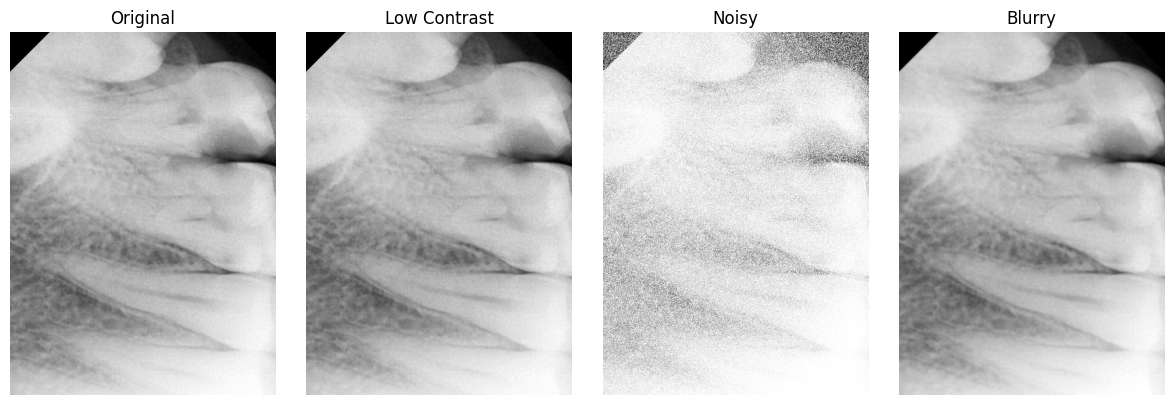

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def simulate_low_contrast(image):
    return cv2.convertScaleAbs(image, alpha=0.5, beta=20)

def simulate_noise(image):
    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    return cv2.add(image, noise)

def simulate_blur(image):
    return cv2.GaussianBlur(image, (7, 7), 0)

# Load original
img = load_dicom_image("/kaggle/input/dicom-data/Images/IS20250115_171841_9465_61003253.dcm")

# Create examples
img_low_contrast = simulate_low_contrast(img)
img_noisy = simulate_noise(img)
img_blurry = simulate_blur(img)

# Visualize
plt.figure(figsize=(12,4))
for i, (title, image) in enumerate([
    ("Original", img),
    ("Low Contrast", img_low_contrast),
    ("Noisy", img_noisy),
    ("Blurry", img_blurry)
]):
    plt.subplot(1, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


**4.(Optional) ML Model Stub (Skeleton Code)**

**architecture without full training:**

In [85]:
from tensorflow.keras import layers, models

def build_quality_classifier(input_shape=(256, 256, 1)):
    model = models.Sequential([
        layers.Input(input_shape),
        layers.Conv2D(16, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')  # classes: low_contrast, noise, blur
    ])
    return model

classifier = build_quality_classifier()
classifier.summary()


2025-05-23 06:03:53.884903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747980234.142447      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747980234.221982      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-23 06:04:10.822726: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       8,388,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,393,667 (32.02 MB)

 Trainable params: 8,393,667 (32.02 MB)

 Non-trainable params: 0 (0.00 B)

This ML-based direction has strong potential for fully adaptive preprocessing.
In real-world settings, such learned strategies could outperform static rules and heuristics, especially with large, diverse datasets.

**Next Steps (Future Work)**:
- Augment data with synthetic degradation
- Train a small CNN or ResNet for quality classification
- Experiment with U-Net-style architectures for end-to-end enhancement


In [90]:
def get_sharpness(image):
    image_uint8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return cv2.Laplacian(image_uint8, cv2.CV_64F).var()

def get_noise(image):
    image_uint8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    blur = cv2.GaussianBlur(image_uint8, (3, 3), 0)
    noise = image_uint8 - blur
    return np.var(noise)


In [93]:
def adaptive_denoise(image, noise_level):
    # Convert image to uint8 for denoising
    image_uint8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    if noise_level > 30:
        return cv2.fastNlMeansDenoising(image_uint8, h=10)
    elif noise_level > 15:
        return cv2.bilateralFilter(image_uint8, 9, 75, 75)
    else:
        return image_uint8


# Representative visual comparisons (Original vs. Static vs. Adaptive) for various image types.


In [94]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

def display_preprocessing_comparison(dicom_path):
    """
    Given a DICOM file path, displays:
    - Raw image
    - Static preprocessed image
    - Adaptive preprocessed image (Approach 1)
    - Adaptive preprocessed image (Approach 2)
    """
    # Step 1: Load DICOM image
    dicom_data = pydicom.dcmread(dicom_path)
    raw_image = dicom_data.pixel_array.astype(np.float32)

    # Step 2: Preprocessing
    static_image = static_preprocessing_pipeline(raw_image)

    # Adaptive 1
    adaptive1_image = adaptive_preprocess(raw_image)

    # Adaptive 2
    brightness = get_brightness(raw_image)
    contrast = get_contrast(raw_image)
    sharpness = get_sharpness(raw_image)
    noise_level = get_noise(raw_image)

    adaptive2_image = dynamic_adaptive_preprocessing(raw_image, brightness, contrast, sharpness, noise_level)

    # Step 3: Visualization
    images = [raw_image, static_image, adaptive1_image, adaptive2_image]
    titles = ["Raw Image", "Static Preprocessing", "Adaptive 1", "Adaptive 2"]

    plt.figure(figsize=(16, 4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


**1st image**

Applying static pipeline...
Brightness: 174.68, Contrast: 49.16, Sharpness: 82.74, Noise: 14057.05
Strategy: Mild CLAHE + Gaussian Blur


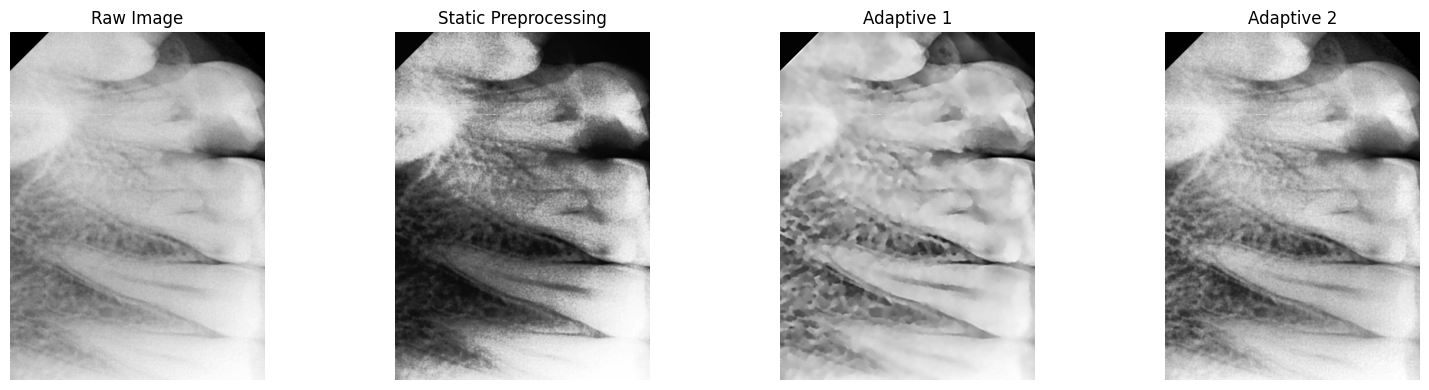

In [95]:
display_preprocessing_comparison("/kaggle/input/dicom-data/Images/IS20250115_171841_9465_61003253.dcm")


**2nd image**

Applying static pipeline...
Brightness: 130.84, Contrast: 76.73, Sharpness: 116.70, Noise: 14949.02
Strategy: Mild CLAHE + Gaussian Blur


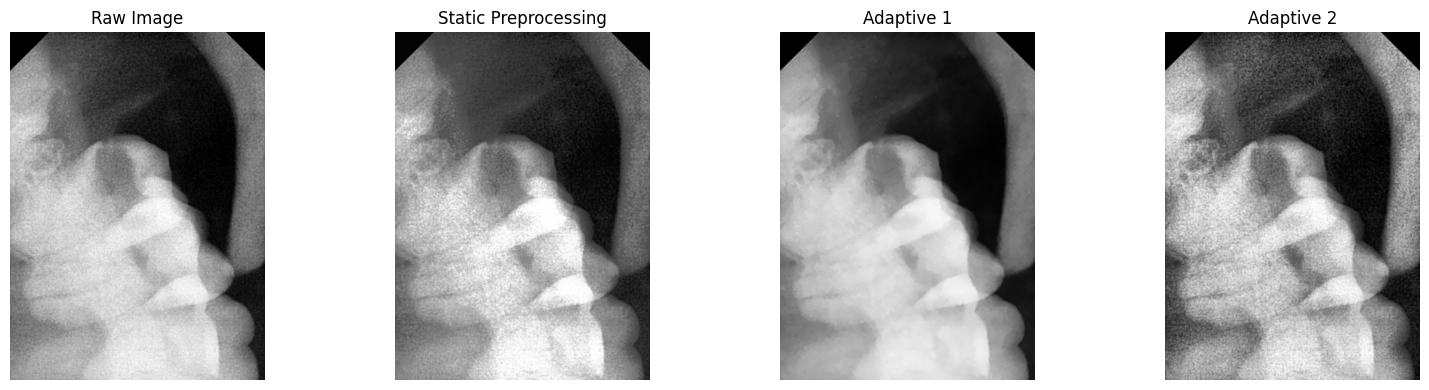

In [96]:
display_preprocessing_comparison("/kaggle/input/dicom-data/Images/IS20250115_190348_9148_86297118.dcm")


**3rd image**

Applying static pipeline...
Brightness: 127.78, Contrast: 72.30, Sharpness: 101.51, Noise: 14839.78
Strategy: Mild CLAHE + Gaussian Blur


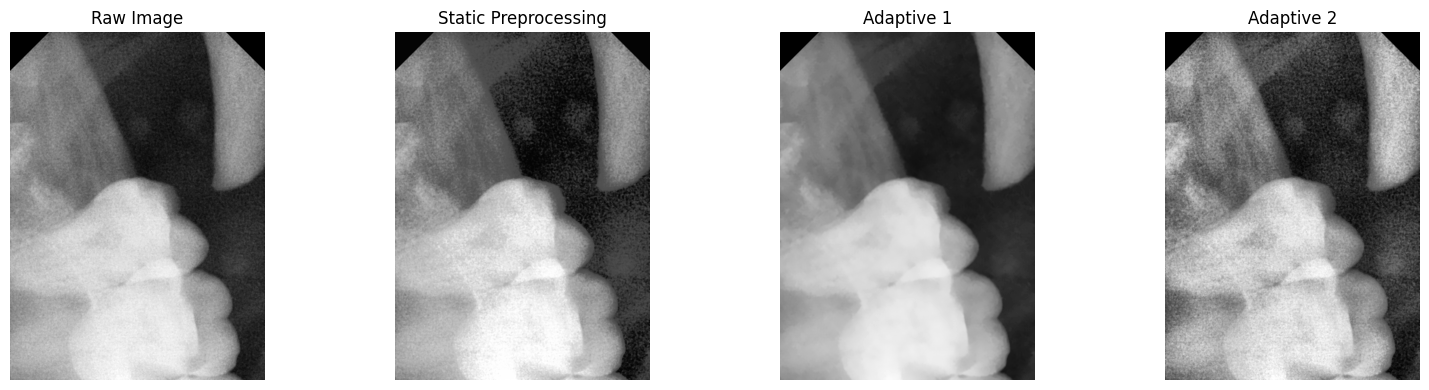

In [97]:
display_preprocessing_comparison("/kaggle/input/dicom-data/Images/IS20250115_191316_7227_10120577.dcm")

**4th image**

Applying static pipeline...
Brightness: 116.35, Contrast: 83.57, Sharpness: 89.44, Noise: 14845.28
Strategy: Mild CLAHE + Gaussian Blur


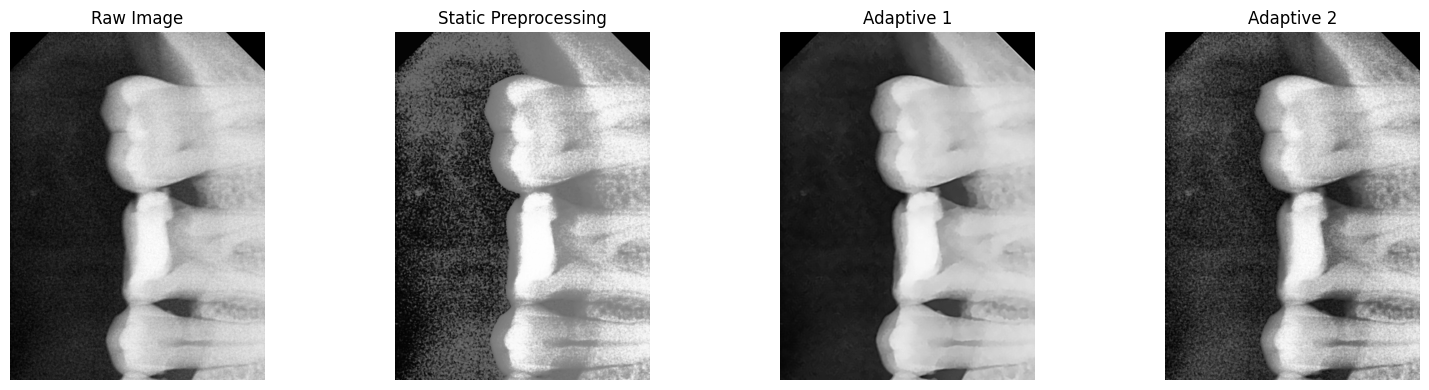

In [98]:
display_preprocessing_comparison("/kaggle/input/dicom-data/Images/IS20250116_180218_7445_56958340.dcm")

**5th image**

Applying static pipeline...
Brightness: 175.43, Contrast: 50.17, Sharpness: 175.70, Noise: 15115.18
Strategy: Mild CLAHE + Gaussian Blur


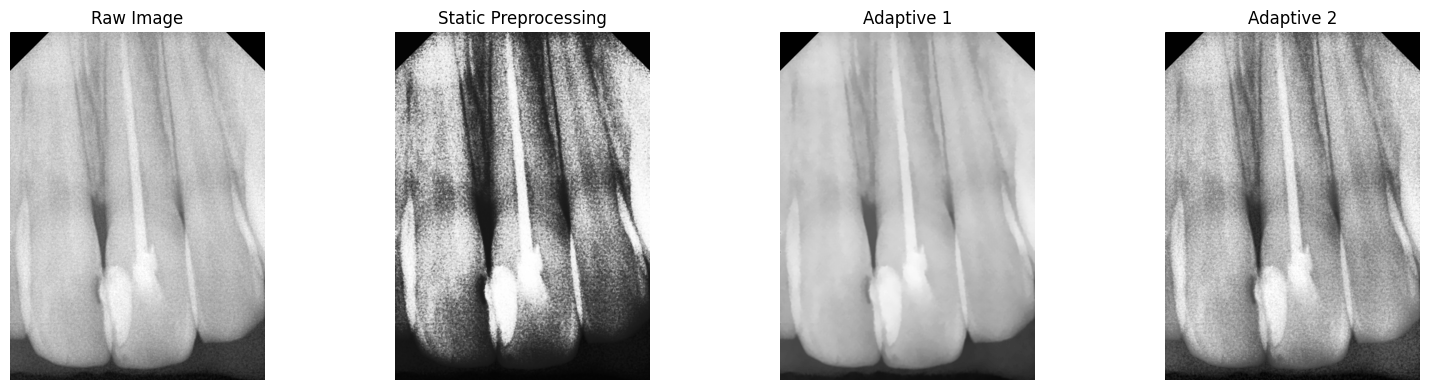

In [99]:
display_preprocessing_comparison("/kaggle/input/dicom-data/Images/IS20250218_193552_3393_78829426.dcm")

**7th image**

Applying static pipeline...
Brightness: 142.20, Contrast: 43.95, Sharpness: 373.52, Noise: 15405.89
Strategy: Mild CLAHE + Gaussian Blur


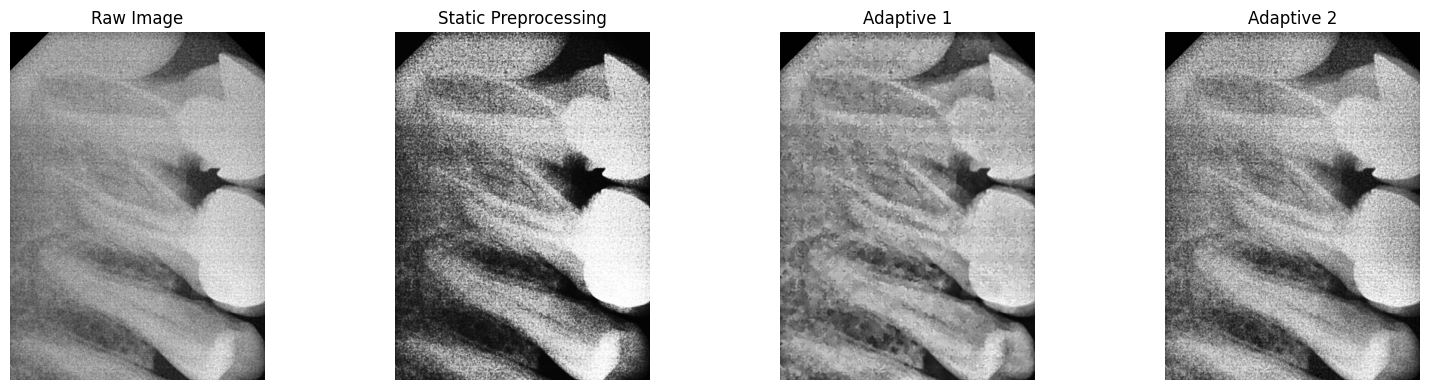

In [101]:
display_preprocessing_comparison("/kaggle/input/dicom-data/Images/IS20250221_192657_5718_56712676.dcm")